# Histopathologic Cancer Classification

## Description
This is notebook to build CNN model for Histopathologic cancer classification. The intention is use this CNN modelmodel to classify image if it's a cancer or not. Our aim is get classification model with the most accuracy possible.

## Data Overview

source : https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

data type : TIFF images (220,025 images)

data size : 6.31 GB

Images are 96x96 RGB pixels

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

In [2]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# check all possible labels and count of each
lb, lb_c = np.unique(train_labels['label'], return_counts=True)
print(lb, ' ', lb_c)

[0 1]   [130908  89117]


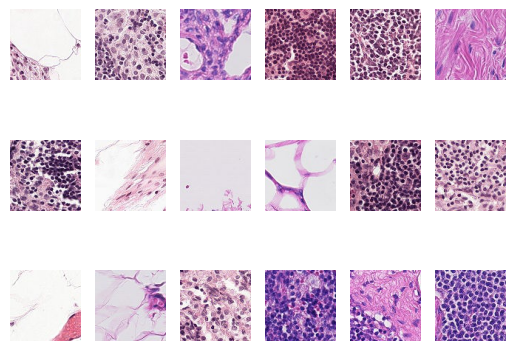

In [4]:
# show negative sample
neg = train_labels[train_labels.label == 0]

neg_image = []
for i in neg['id'].head(18):
    neg_image.append(Image.open('./histopathologic-cancer-detection/train/'+i+'.tif'))

fix, axs = plt.subplots(3, 6)
axs = axs.flatten()
for img, ax in zip(neg_image, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

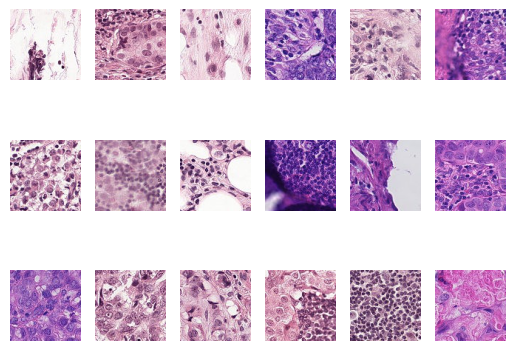

In [5]:
# show positive sample
pos = train_labels[train_labels.label == 1]

pos_image = []
for i in pos['id'].head(18):
    pos_image.append(Image.open('./histopathologic-cancer-detection/train/'+i+'.tif'))

fix, axs = plt.subplots(3, 6)
axs = axs.flatten()
for img, ax in zip(pos_image, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

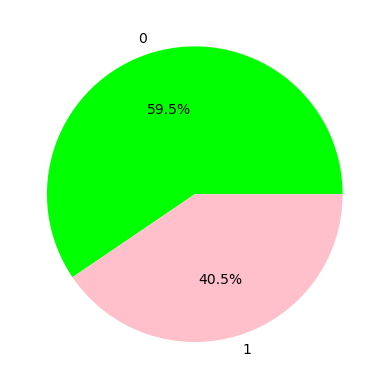

In [6]:
# show labels ratio of training data
plt.pie(lb_c, labels = lb, autopct='%1.1f%%', colors=['lime','pink'])
plt.show() 

From pie chart above we can see that we have training data of positive label less than can negative label about 10%.

### Analysis
We have huge training data and in this training data it have negative label more than positive label. We didn't get much information with sample images. Most color of image is purple and white. So, Maybe we can do gray scale to reduce training time and not effect much on accuracy.

## Classification
First, I will try with simple CNN model as based line. Then, try again with more complex model. Also, I would use hyper parameter technique to improve accuracy.

In [7]:
# prepare df
train_labels['label'] = train_labels['label'].astype(str)
train_labels['id'] = train_labels['id'].add('.tif')

In [21]:
# gen training and validation data (validation 20%)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = datagen.flow_from_dataframe(
    train_labels,
    directory = './histopathologic-cancer-detection/train/',
    x_col = 'id',
    y_col = 'label',
    target_size = (96,96),
    class_mode='binary',
    seed = 1992,
    save_format = 'tif',
    subset = 'training'
)

val_ds = datagen.flow_from_dataframe(
    train_labels,
    directory = './histopathologic-cancer-detection/train/',
    x_col = 'id',
    y_col = 'label',
    target_size = (96,96),
    class_mode='binary',
    seed = 1992,
    save_format = 'tif',
    subset = 'validation'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [15]:
# build base model
model0 = Sequential([
  layers.Conv2D(16, 3, activation='relu', input_shape=(96, 96, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='sigmoid'),
  layers.Dense(1)
])

In [16]:
model0.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 47, 47, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 10, 64)       

In [17]:
epochs=20
%time history = model0.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
   1/5501 [..............................] - ETA: 25:11 - loss: 0.2885 - accuracy: 0.7500

2023-08-09 17:41:42.884851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5500/5501 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.8065

2023-08-09 17:43:22.305372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 116s 21ms/step - loss: 0.1388 - accuracy: 0.8065 - val_loss: 0.1323 - val_accuracy: 0.8128
Epoch 2/20
5501/5501 [==============================] - 116s 21ms/step - loss: 0.1070 - accuracy: 0.8550 - val_loss: 0.0945 - val_accuracy: 0.8725
Epoch 3/20
5501/5501 [==============================] - 115s 21ms/step - loss: 0.0924 - accuracy: 0.8767 - val_loss: 0.0863 - val_accuracy: 0.8860
Epoch 4/20
5501/5501 [==============================] - 124s 22ms/step - loss: 0.0844 - accuracy: 0.8887 - val_loss: 0.0858 - val_accuracy: 0.8867
Epoch 5/20
5501/5501 [==============================] - 125s 23ms/step - loss: 0.0792 - accuracy: 0.8969 - val_loss: 0.0818 - val_accuracy: 0.8932
Epoch 6/20
5501/5501 [==============================] - 117s 21ms/step - loss: 0.0744 - accuracy: 0.9040 - val_loss: 0.0737 - val_accuracy: 0.9050
Epoch 7/20
5501/5501 [==============================] - 117s 21ms/step - loss: 0.0696 - accuracy: 0.9093 - val_loss: 0.0719 - val

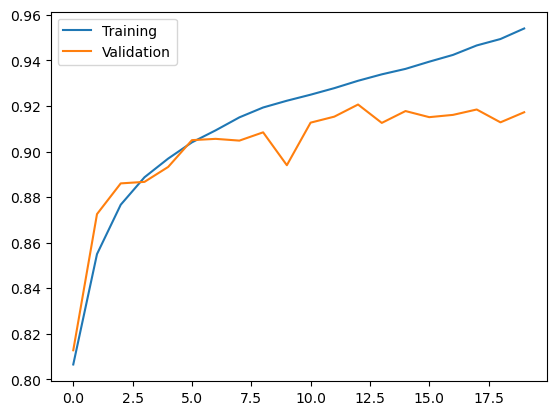

In [18]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [45]:
# prepare df
test_labels = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')
test_labels['filename'] = test_labels['id'].add('.tif')

In [46]:
test_ds = datagen.flow_from_dataframe(
    test_labels,
    directory = './histopathologic-cancer-detection/test/',
    x_col = 'filename',
    y_col = None,
    target_size = (96,96),
    class_mode=None,
    shuffle=False,
    seed = 1992,
    save_format = 'tif'
)

Found 57458 validated image filenames.


In [55]:
predictions = model0.predict(test_ds)

output = pd.DataFrame({'id': test_labels.id, 'label': predictions.flatten()})
output.to_csv('submission0.csv', index=False)
print("Your submission was successfully saved!")

1796/1796 [==============================] - 21s 12ms/step
Your submission was successfully saved!


Score for submit this prediction to Kaggle private = 0.8777 public=0.9186

Next, I will try with more complex model which shoud have higher accuracy.

In [71]:
model1 = Sequential([
  layers.Conv2D(16, 3, activation='relu', input_shape=(96, 96, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='sigmoid'),
  layers.Dense(1)
])

In [72]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 47, 47, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 10, 10, 64)       

In [73]:
epochs=10
%time history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
   1/5501 [..............................] - ETA: 52:40 - loss: 0.7247 - accuracy: 0.7188

2023-08-09 19:17:17.142858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5500/5501 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.8006

2023-08-09 19:18:58.277081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 118s 21ms/step - loss: 0.1416 - accuracy: 0.8006 - val_loss: 0.1185 - val_accuracy: 0.8378
Epoch 2/10
5501/5501 [==============================] - 120s 22ms/step - loss: 0.1091 - accuracy: 0.8505 - val_loss: 0.0968 - val_accuracy: 0.8698
Epoch 3/10
5501/5501 [==============================] - 119s 22ms/step - loss: 0.0944 - accuracy: 0.8716 - val_loss: 0.0919 - val_accuracy: 0.8742
Epoch 4/10
5501/5501 [==============================] - 120s 22ms/step - loss: 0.0889 - accuracy: 0.8800 - val_loss: 0.0964 - val_accuracy: 0.8705
Epoch 5/10
5501/5501 [==============================] - 119s 22ms/step - loss: 0.0924 - accuracy: 0.8758 - val_loss: 0.0979 - val_accuracy: 0.8643
Epoch 6/10
5501/5501 [==============================] - 118s 22ms/step - loss: 0.0986 - accuracy: 0.8664 - val_loss: 0.0930 - val_accuracy: 0.8770
Epoch 7/10
5501/5501 [==============================] - 123s 22ms/step - loss: 0.1005 - accuracy: 0.8654 - val_loss: 0.0946 - val

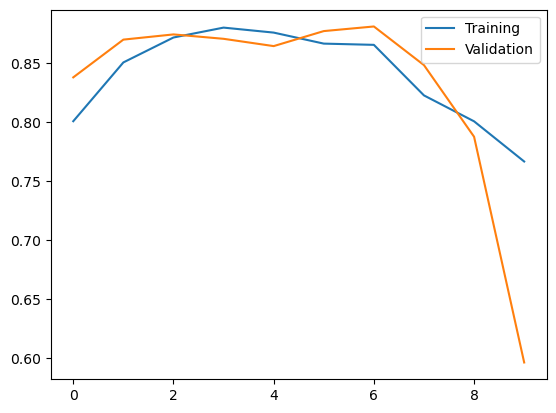

In [74]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

From graph above, I think accuracy due to learing rate was too high. So, I will try again with lower learing rate and change a bit of a model.

In [128]:
model2 = Sequential([
  layers.Conv2D(16, 3, activation='relu', input_shape=(96, 96, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [129]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_103 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 47, 47, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_87 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_88 (MaxPooli  (None, 10, 10, 64)      

In [130]:
epochs=15
%time history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15


2023-08-09 20:14:19.103442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5499/5501 [============================>.] - ETA: 0s - loss: 0.4693 - accuracy: 0.7825

2023-08-09 20:16:04.372857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 122s 22ms/step - loss: 0.4693 - accuracy: 0.7825 - val_loss: 0.4541 - val_accuracy: 0.7967
Epoch 2/15
5501/5501 [==============================] - 120s 22ms/step - loss: 0.4386 - accuracy: 0.8022 - val_loss: 0.4445 - val_accuracy: 0.7962
Epoch 3/15
5501/5501 [==============================] - 116s 21ms/step - loss: 0.4581 - accuracy: 0.7920 - val_loss: 0.4196 - val_accuracy: 0.8140
Epoch 4/15
5501/5501 [==============================] - 117s 21ms/step - loss: 0.4206 - accuracy: 0.8140 - val_loss: 0.4216 - val_accuracy: 0.8218
Epoch 5/15
5501/5501 [==============================] - 128s 23ms/step - loss: 0.4083 - accuracy: 0.8221 - val_loss: 0.3861 - val_accuracy: 0.8317
Epoch 6/15
5501/5501 [==============================] - 177s 32ms/step - loss: 0.4507 - accuracy: 0.8051 - val_loss: 0.4396 - val_accuracy: 0.7998
Epoch 7/15
5501/5501 [==============================] - 162s 29ms/step - loss: 0.4301 - accuracy: 0.8135 - val_loss: 0.3850 - val

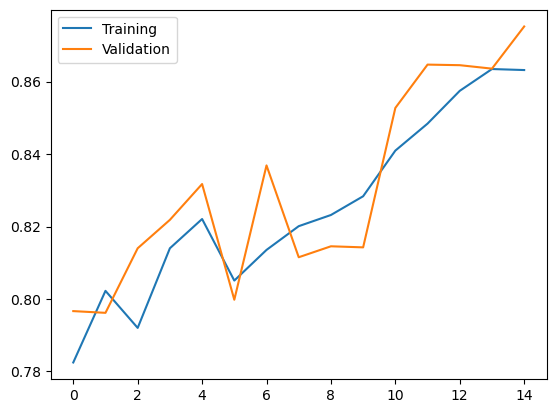

In [131]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

This model seem to need more time to reach optimal. I want to train this more del with more epochs but I don't have time for that. Therefore, I will submit this as my last submittion.

Score for submit this prediction to Kaggle private = 0.8937 public=0.9034

## Conclusion
First we look up trainig data and try some analysis. Then we build CNN model and tune it to get the best model (on accuracy). I think learing rate and epochs are very import hyper-parameter in this project. We should select proper earing rate and epochs for the best result (in term of accuracy and time to train the model). We also, can see that CNN model took lot of time to train, even simple CCN model. Therefore, we should ensure everything before training CNN model. For kaggle score I think this is good enough for me since it's my first CNN project.

github : https://github.com/Satjarporn/cancer